In [1]:
# Install from kaggle datasets for code competition

# Install transformers 2.3.0
! pip install -q ../input/sacremoses/sacremoses-master/
! pip install -q ../input/transformers-2-3-0/

# Install Nvidia Apex
! pip install -q -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" /kaggle/input/nvidia-apex/apex-880ab92

/opt/conda/lib/python3.6/site-packages/pip/_internal/commands/install.py:243: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Processing /kaggle/input/nvidia-apex/apex-880ab92
Skipping bdist_wheel for apex, due to binaries being disabled for it.
  Running setup.py install for apex ... - \ | / - \ | / - \ | / - \ | / - \ | / - done


In [2]:
from __future__ import absolute_import, division, print_function

import os, sys, re, gc, pickle, operator, shutil, copy, random
import time, datetime

from math import floor, ceil
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader, Sampler

from apex import amp
import transformers
from transformers import *

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

print(f'torch version: {torch.__version__}')
print(f'transformers version: {transformers.__version__}')

torch version: 1.2.0
transformers version: 2.3.0


# Configuration

In [3]:
DATA_DIR = "/kaggle/input/google-quest-challenge/"
VOCAB_PATH = "/kaggle/input/bert-pretrained-models/uncased_L-12_H-768_A-12/uncased_L-12_H-768_A-12/"
MODEL_PATH = "/kaggle/input/bert-pytorch/"
output_model_file = "quest_bert_models.pt"

SEED = 2019
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

MAX_SEQUENCE_LENGTH = 512
batch_size = 8
grad_accumulation_steps = 2

In [4]:
# Seed for randomness in pytorch
def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything()

# Datasets

In [5]:
def trim_and_tokenize(title, question, answer, max_sequence_length, tokenizer,
                      trunc_mode='head', t_max_len=18, q_max_len=245, a_max_len=244):
    """
    trunc_mode:
    - head: truncate sequence from head
    - tail: truncate sequence from tail
    - mix: concatenate truncated sequences from head and tail 6:4 for each
    """
    
    assert trunc_mode in {"head", "tail", "mix"}
    need_trunc = False

    tq_sep = tokenizer.tokenize("Details:")
    t = tokenizer.tokenize(title)
    q = tokenizer.tokenize(question)
    a = tokenizer.tokenize(answer)
    
    t_len = len(t)
    q_len = len(q)
    a_len = len(a)

    if (t_len+q_len+a_len+5) > max_sequence_length:
        need_trunc = True
        
        if t_max_len > t_len:
            t_new_len = t_len
            a_max_len = a_max_len + floor((t_max_len - t_len)/2)
            q_max_len = q_max_len + ceil((t_max_len - t_len)/2)
        else:
            t_new_len = t_max_len
      
        if a_max_len > a_len:
            a_new_len = a_len 
            q_new_len = q_max_len + (a_max_len - a_len)
        elif q_max_len > q_len:
            a_new_len = a_max_len + (q_max_len - q_len)
            q_new_len = q_len
        else:
            a_new_len = a_max_len
            q_new_len = q_max_len
            
        if t_new_len+a_new_len+q_new_len+5 != max_sequence_length:
            raise ValueError("New sequence length should be %d, but is %d" 
                             % (max_sequence_length, (t_new_len+a_new_len+q_new_len+5)))
        
        if trunc_mode == "head":
            t = t[:t_new_len]
            q = q[:q_new_len]
            a = a[:a_new_len]
        if trunc_mode == "tail":
            t = t[-t_new_len:]
            q = q[-q_new_len:]
            a = a[-a_new_len:]
        if trunc_mode == "mix":
            def trunc_seq(seq, seq_max_len, trunc_ratio=0.6):
                maj_len = int(seq_max_len * trunc_ratio)
                return seq[:maj_len] + seq[-(seq_max_len-maj_len):]
            t = trunc_seq(t, t_new_len)
            q = trunc_seq(q, q_new_len)
            a = trunc_seq(a, a_new_len)
    
    return t, tq_sep, q, a, need_trunc


# Tokenizing the lines to BERT token
def convert_lines(df, columns, max_sequence_length, tokenizer, trunc_mode='head',
                  misc_trunc=False, target=None, sample_weighting=False):
    """
    trunc_mode:
    - head: truncate sequence from head
    - tail: truncate sequence from tail
    - mix: concatenate truncated sequences from head and tail 6:4 for each
    
    misc_trunc: use miscellaneous truncation or not
    
    sample_weighting: when misc_trunc=True, weighting on different truncated samples
    """
    
    all_tokens = []
    segment_ids = []   # representing segmentation of sentence A and B
    if target is not None:
        labels = []
    
    for ind, (_, instance) in enumerate(df[columns].iterrows()):
        
        title, question, answer = instance.question_title, instance.question_body, instance.answer
        t, tq_sep, q, a, need_trunc = trim_and_tokenize(title, question, answer,
                                                        max_sequence_length, tokenizer, trunc_mode=trunc_mode)
        tokens = ["[CLS]"] + t + tq_sep + q + ["[SEP]"] + a + ["[SEP]"]
        all_tokens.append(tokenizer.convert_tokens_to_ids(tokens))
        segment_ids.append([0]*(len(t)+len(tq_sep)+len(q)+2) + [1]*(len(a)+1))
        if target is not None:
            if sample_weighting:
                labels.append(np.concatenate([target[ind], [3./7]]))
            else:
                labels.append(target[ind])
        
        if need_trunc and misc_trunc:
            t, tq_sep, q, a, _ = trim_and_tokenize(title, question, answer,
                                                   max_sequence_length, tokenizer, trunc_mode='tail')
            tokens = ["[CLS]"] + t + tq_sep + q + ["[SEP]"] + a + ["[SEP]"]
            all_tokens.append(tokenizer.convert_tokens_to_ids(tokens))
            segment_ids.append([0]*(len(t)+len(tq_sep)+len(q)+2) + [1]*(len(a)+1))

            t, tq_sep, q, a, _ = trim_and_tokenize(title, question, answer,
                                                   max_sequence_length, tokenizer, trunc_mode='mix')
            tokens = ["[CLS]"] + t + tq_sep + q + ["[SEP]"] + a + ["[SEP]"]
            all_tokens.append(tokenizer.convert_tokens_to_ids(tokens))
            segment_ids.append([0]*(len(t)+len(tq_sep)+len(q)+2) + [1]*(len(a)+1))

            if target is not None:
                if sample_weighting:
                    labels.extend([np.concatenate([target[ind], [2./7]])] * 2)
                else:
                    labels.extend([target[ind]] * 2)
    
    if target is not None:
        return np.array(all_tokens), np.array(segment_ids), np.array(labels)
    return np.array(all_tokens), np.array(segment_ids)

In [6]:
# Prepare dataset and dataloader

class QuestQAs(Dataset):

    def __init__(self, tokenized_comments, segment_ids, targets=None, split=None, maxlen=256):
        self.comments = tokenized_comments
        self.segment_ids = segment_ids
        self.targets = targets
        self.split = split
        assert self.split in {'train', 'valid', 'test'}
        self.maxlen = maxlen

    def __getitem__(self, index):
        comment = self.comments[index]
        segment_id = self.segment_ids[index]
        if self.targets is not None:
            target = self.targets[index]
            return comment, segment_id, torch.FloatTensor(target)
        else:
            return comment, segment_id

    def __len__(self):
        return len(self.comments)

    def get_lens(self):
        lengths = np.fromiter(
            ((min(self.maxlen, len(seq))) for seq in self.comments),
            dtype=np.int32)
        return lengths

    def collate_fn(self, batch):
        """
        Collate function for sequence bucketing
        Note: this need not be defined in this Class, can be standalone.

        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of comments, and targets
        """

        if self.split in ('train', 'valid'):
            comments, segment_ids, targets = zip(*batch)
        else:
            comments, segment_ids = zip(*batch)

        lengths = [len(c) for c in comments]
        maxlen = max(lengths)
        padded_comments, padded_seg_ids = [], []
        for i, (c, s) in enumerate(zip(comments, segment_ids)):
            padded_comments.append(c+[0]*(maxlen - lengths[i]))
            padded_seg_ids.append(s +[0]*(maxlen - lengths[i]))

        if self.split in ('train', 'valid'):
            return torch.LongTensor(padded_comments), torch.LongTensor(padded_seg_ids), torch.stack(targets)
        else:
            return torch.LongTensor(padded_comments), torch.LongTensor(padded_seg_ids)


class BucketSampler(Sampler):

    def __init__(self, data_source, sort_lens, bucket_size=None, batch_size=1024, shuffle_data=True):
        super().__init__(data_source)
        self.shuffle = shuffle_data
        self.batch_size = batch_size
        self.sort_lens = sort_lens
        self.bucket_size = bucket_size if bucket_size is not None else len(sort_lens)
        self.weights = None

        if not shuffle_data:
            self.index = self.prepare_buckets()
        else:
            self.index = None

    def set_weights(self, weights):
        assert weights >= 0
        total = np.sum(weights)
        if total != 1:
            weights = weights / total
        self.weights = weights

    def __iter__(self):
        indices = None
        if self.weights is not None:
            total = len(self.sort_lens)
            indices = np.random.choice(total, (total,), p=self.weights)
        if self.shuffle:
            self.index = self.prepare_buckets(indices)
        return iter(self.index)

    def get_reverse_indexes(self):
        indexes = np.zeros((len(self.index),), dtype=np.int32)
        for i, j in enumerate(self.index):
            indexes[j] = i
        return indexes

    def __len__(self):
        return len(self.sort_lens)

    def prepare_buckets(self, indices=None):
        lengths = - self.sort_lens
        assert self.bucket_size % self.batch_size == 0 or self.bucket_size == len(lengths)

        if indices is None:
            if self.shuffle:
                indices = shuffle(np.arange(len(lengths), dtype=np.int32))
                lengths = lengths[indices]
            else:
                indices = np.arange(len(lengths), dtype=np.int32)

        #  bucket iterator
        def divide_chunks(l, n):
            if n == len(l):
                yield np.arange(len(l), dtype=np.int32), l
            else:
                # looping till length l
                for i in range(0, len(l), n):
                    data = l[i:i + n]
                    yield np.arange(i, i + len(data), dtype=np.int32), data

        new_indices = []
        extra_batch_idx = None
        for chunk_index, chunk in divide_chunks(lengths, self.bucket_size):
            # sort indices in bucket by descending order of length
            indices_sorted = chunk_index[np.argsort(chunk)]

            batch_idxes = []
            for _, batch_idx in divide_chunks(indices_sorted, self.batch_size):
                if len(batch_idx) == self.batch_size:
                    batch_idxes.append(batch_idx.tolist())
                else:
                    assert extra_batch_idx is None
                    assert batch_idx is not None
                    extra_batch_idx = batch_idx.tolist()

            # shuffling batches within buckets
            if self.shuffle:
                batch_idxes = shuffle(batch_idxes)
            for batch_idx in batch_idxes:
                new_indices.extend(batch_idx)

        if extra_batch_idx is not None:
            new_indices.extend(extra_batch_idx)

        if not self.shuffle:
            self.original_indices = np.argsort(indices_sorted).tolist()
        return indices[new_indices]


def prepare_loader(x, seg_ids, y=None, batch_size=None, split=None):
    assert split in {'train', 'valid', 'test'}
    dataset = QuestQAs(x, seg_ids, y, split, MAX_SEQUENCE_LENGTH)
    if split == 'train':
        sampler = BucketSampler(dataset, dataset.get_lens(),
                                bucket_size=batch_size*20, batch_size=batch_size)
        return DataLoader(dataset, batch_size=batch_size, sampler=sampler,
                          collate_fn=dataset.collate_fn)
    else:
        sampler = BucketSampler(dataset, dataset.get_lens(),
                                batch_size=batch_size, shuffle_data=False)
        return DataLoader(dataset, batch_size=batch_size, sampler=sampler,
                          collate_fn=dataset.collate_fn), sampler.original_indices

In [7]:
def train_val_split(train_df):
    kf = GroupKFold(n_splits=5)
#     kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    cv_indices = list(kf.split(train_df.question_body, groups=train_df.question_body))
#     cv_indices = list(kf.split(train_df))
    return cv_indices


def load_data():
    train_df = pd.read_csv(DATA_DIR+'train.csv')
    output_cols = list(train_df.columns[11:])
    input_cols = list(train_df.columns[[1,2,5]])
    
    train_tars = train_df[output_cols].values.astype('float32')
    
    return train_tars, train_df, input_cols


def load_and_preproc():
    train_df = pd.read_csv(DATA_DIR+'train.csv')
    output_cols = list(train_df.columns[11:])
    input_cols = list(train_df.columns[[1,2,5]])
    
    train_tars = train_df[output_cols].values.astype('float32')
    train_seq, train_seg_ids = convert_lines(train_df, input_cols, MAX_SEQUENCE_LENGTH, tokenizer)

    return train_seq, train_seg_ids, train_tars, train_df

In [8]:
%%time

tokenizer = BertTokenizer.from_pretrained(VOCAB_PATH + 'vocab.txt')

t0 = time.time()
print('Loading and tokenizing...')
train_tars, train_df, input_cols = load_data()
# train_seq, train_seg_ids, train_tars, train_df = load_and_preproc()
cv_indices = train_val_split(train_df)
trn_idx, val_idx = cv_indices[0]
print('tokenizing complete in {:.0f} seconds.'.format(time.time()-t0))

Loading and tokenizing...
tokenizing complete in 0 seconds.
CPU times: user 201 ms, sys: 30.2 ms, total: 231 ms
Wall time: 347 ms


# Model

In [9]:
# Classifier
class GQuestNet(BertPreTrainedModel):
    def __init__(self, config, num_labels):
        super(GQuestNet, self).__init__(config)
        self.bert = BertModel.from_pretrained(MODEL_PATH+'bert-base-uncased-pytorch_model.bin', config=config)
        self.dropouts = nn.ModuleList([nn.Dropout(0.3) for _ in range(5)])
        self.classifier = nn.Linear(config.hidden_size*4, num_labels)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        _, _, encoded_layers = self.bert(input_ids, attention_mask, token_type_ids)
        seq_op1 = encoded_layers[-1]
        seq_op2 = encoded_layers[-2]
        avg_pool1 = torch.mean(seq_op1, 1)
        max_pool1, _ = torch.max(seq_op1, 1)
        avg_pool2 = torch.mean(seq_op2, 1)
        max_pool2, _ = torch.max(seq_op2, 1)
        pooled_output = torch.cat((avg_pool1, max_pool1, avg_pool2, max_pool2), 1)
        for i, dropout in enumerate(self.dropouts):
            if i == 0:
                h = self.classifier(dropout(pooled_output))
            else:
                h += self.classifier(dropout(pooled_output))
        return h / len(self.dropouts)


class TruncLoss(nn.Module):
    def forward(self, pred_scores, labels):
        loss = 0
        for i in range(pred_scores.size(1)):
            loss += nn.BCEWithLogitsLoss(weight=labels[:,-1])(pred_scores[:,i], labels[:,i])
        return loss


# Build model and optimizer
def model_optimizer_init(ft_lrs, num_labels=30):
    print("Building model and optimizer...")
    cfg = BertConfig.from_pretrained(MODEL_PATH + 'bert-base-uncased-config.json')
    cfg.output_hidden_states = True
    model = GQuestNet(cfg, num_labels=num_labels)

    params_bert = list(model.bert.parameters())
    params_cls = list(model.classifier.parameters())

    optimizer_grouped_parameters = [
        {'params': params_bert, 'lr':ft_lrs[0]},
        {'params': params_cls, 'lr':ft_lrs[1]}
        ]
    
    optimizer = optim.AdamW(optimizer_grouped_parameters)
    
    return model, optimizer

In [10]:
def model_test():
    x = torch.randint(10, (8, 256))
    cfg = BertConfig.from_pretrained(MODEL_PATH + 'bert-base-uncased-config.json')
    cfg.output_hidden_states = True
    model = GQuestNet(cfg, num_labels=30)
    print(model(x).size())

model_test()

torch.Size([8, 30])


# LR range test

In [11]:
# lr range test function


def lr_range_test(train_loader, model, optimizer, criterion, start_lr=1e-7,
                  end_lr=10, num_it=100, stop_div=True):
    epochs = int(np.ceil(num_it/len(train_loader)))
    n_groups = len(optimizer.param_groups)

    if isinstance(start_lr, list) or isinstance(start_lr, tuple):
        if len(start_lr) != n_groups:
            raise ValueError("expected {} max_lr, got {}".format(n_groups, len(start_lr)))
        start_lrs = list(start_lr)
    else:
        start_lrs = [start_lr] * n_groups

    if isinstance(end_lr, list) or isinstance(end_lr, tuple):
        if len(end_lr) != n_groups:
            raise ValueError("expected {} max_lr, got {}".format(n_groups, len(end_lr)))
        end_lrs = list(end_lr)
    else:
        end_lrs = [end_lr] * n_groups

    curr_lrs = start_lrs*1
    for param_group, lr in zip(optimizer.param_groups, curr_lrs):
        param_group['lr'] = lr

    n, lrs_logs, loss_log = 0, [], []

    for e in range(epochs):
        model.train()
        for x, seg_ids, y in train_loader:
            x, y = x.to(device=device, dtype=torch.long), y.to(device=device, dtype=torch.float)
            seg_ids = seg_ids.to(device=device, dtype=torch.long)
            scores = model(x, token_type_ids=seg_ids, attention_mask=(x>0))
            loss = criterion(scores, y)

            optimizer.zero_grad()
#             loss.backward()
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
            optimizer.step()

            lrs_logs.append(curr_lrs)
            loss_log.append(loss.item())

            # update best loss
            if n == 0:
                best_loss, n_best = loss.item(), n
            else:
                if loss.item() < best_loss:
                    best_loss, n_best = loss.item(), n

            # update lr per iter with exponential schedule
            n += 1
            curr_lrs = [lr * (end_lr/lr) ** (n/num_it) for lr, end_lr in zip(start_lrs, end_lrs)]
            for param_group, lr in zip(optimizer.param_groups, curr_lrs):
                param_group['lr'] = lr

            # stopping condition
            if n == num_it or (stop_div and (loss.item() > 4*best_loss or torch.isnan(loss))):
                break

    print('minimum loss {}, at lr {}'.format(best_loss, lrs_logs[n_best]))
    return lrs_logs, loss_log


def plot_lr_test(lrs_logs, loss_log, front_cut=10, tail_cut=4):
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs_logs[-1][front_cut:-tail_cut], loss_log[front_cut:-tail_cut])
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    plt.show()

In [12]:
def run_range_test():
    for i, (trn_idx, val_idx) in enumerate(cv_indices):
        print(f'Fold {i+1}')
        x_train, seg_train, y_train = convert_lines(train_df.iloc[trn_idx], input_cols,
                                                    MAX_SEQUENCE_LENGTH, tokenizer,
                                                    misc_trunc=True, target=train_tars[trn_idx],
                                                    sample_weighting=True)
        x_val, seg_val = convert_lines(train_df.iloc[val_idx], input_cols,
                                       MAX_SEQUENCE_LENGTH, tokenizer)
        
        y_val = train_tars[val_idx]
        y_val = np.hstack([y_val, np.ones(len(y_val), dtype='float32')[:,None]])
        
        train_loader = prepare_loader(x_train, seg_train, y_train, batch_size, split='train')
        val_loader, val_original_indices = prepare_loader(x_val, seg_val, y_val, 16, split='valid')
        print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)
        
        lr = 1e-3
        ft_lrs = [0.8*lr, lr]
        model, optimizer = model_optimizer_init(ft_lrs)
        model = model.to(device)
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

        lrs_logs, loss_log = lr_range_test(train_loader, model.to(device), optimizer, TruncLoss().to(device), 
                                           start_lr=(8e-8,1e-7), end_lr=(8,10))
        lrs_logs = list(zip(*lrs_logs))
        torch.cuda.empty_cache()
        
        plot_lr_test(lrs_logs, loss_log)

Fold 1
(7473,) (1216,) (7473, 31) (1216, 31)
Building model and optimizer...
minimum loss 3.786926031112671, at lr [0.002009509145207666, 0.002511886431509582]


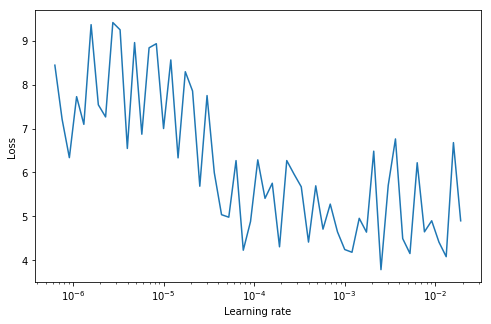

Fold 2
(7439,) (1216,) (7439, 31) (1216, 31)
Building model and optimizer...
minimum loss 3.82904052734375, at lr [0.0002203382962670533, 0.0002754228703338166]


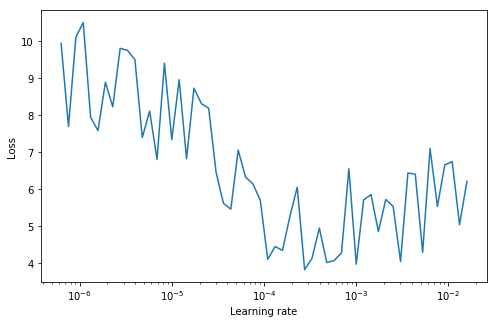

Fold 3
(7535,) (1216,) (7535, 31) (1216, 31)
Building model and optimizer...
minimum loss 3.7191247940063477, at lr [0.0001524368574370597, 0.00019054607179632462]


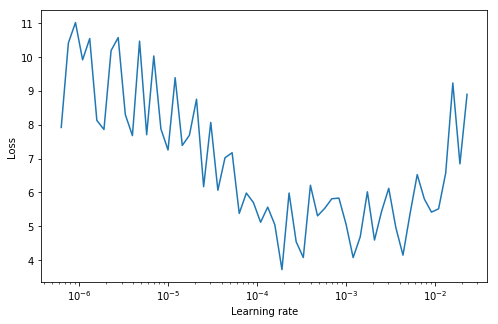

Fold 4
(7491,) (1216,) (7491, 31) (1216, 31)
Building model and optimizer...
minimum loss 3.575331926345825, at lr [0.0004603519498697253, 0.0005754399373371565]


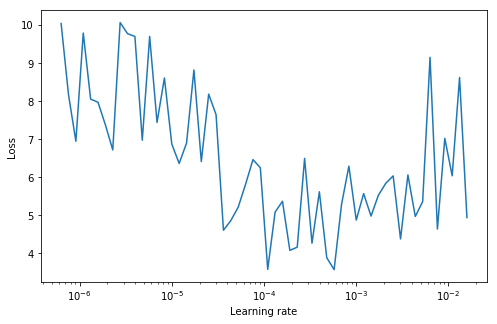

Fold 5
(7474,) (1215,) (7474, 31) (1215, 31)
Building model and optimizer...
minimum loss 3.952573537826538, at lr [0.000553464776735149, 0.0006918309709189362]


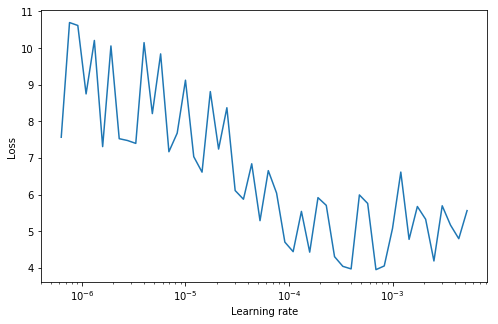

In [13]:
run_range_test()